# **Buynomics - Price Optimization Task**

### Importing Libraries

In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
import sklearn
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

import warnings
warnings.filterwarnings("ignore")

### **Initial Data Exploration: Sales Data**

In [2]:
# reading sales data
sales = pd.read_csv("sales copy.csv", index_col =0)
sales.sample(7, random_state = 42)

,date,product_id,price,units
30,2020-01-01,3,2.70,1478.0
186,2020-01-07,18,3.88,1559.0
232,2020-01-03,23,4.65,1144.0
190,2020-01-01,19,9.10,345.0
220,2020-01-01,22,6.15,826.0
268,2020-01-09,26,3.38,1603.0
178,2020-01-09,17,4.17,1057.0


In [3]:
# dimesions of data
sales.shape

(260, 4)

In [4]:
# sum of NA values in each columns
sales.isna().sum()

date          0
product_id    0
price         0
units         0
dtype: int64

In [5]:
# the number of duplicate values in each column
duplicate_counts = sales.apply(lambda col: col.duplicated().sum())

print(duplicate_counts)

date          250
product_id    233
price          42
units          26
dtype: int64


In [6]:
# info about null values and data types
sales.info()

<class 'pandas.core.frame.DataFrame'>
Index: 260 entries, 0 to 269
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   date        260 non-null    object 
 1   product_id  260 non-null    int64  
 2   price       260 non-null    float64
 3   units       260 non-null    float64
dtypes: float64(2), int64(1), object(1)
memory usage: 10.2+ KB


<span style="color:red;font-size:14px">[Note] Date column needs to be converted to timestamp </span>

In [7]:
sales.describe().T

,count,mean,std,min,25%,50%,75%,max
product_id,260.0,12.911538,7.846738,0.00,6.000,13.00,20.000,26.00
price,260.0,5.288538,1.881547,1.46,3.965,5.14,6.785,9.42
units,260.0,1177.496154,401.771103,16.00,944.000,1275.50,1453.250,2170.00


### **Initial Data Exploration: Product Data**

In [8]:
# reading product data
product = pd.read_csv("product copy.csv", index_col = 0)
product.sample(7, random_state = 42)

,brand,flavour,volume_per_joghurt_g,packsize,product_id
8,Alnatura,straciatella,150,6,8
13,Danone,chocolate,150,6,13
9,Activia,blueberry,1000,6,9
21,Danone,strawberry,1000,6,21
0,Mueller,blueberry,150,6,0
11,Ja!,blueberry,500,6,11
16,Ja!,straciatella,500,6,16


In [9]:
# dimensions of data
product.shape

(27, 5)

In [10]:
# sum of NA values in each column
product.isna().sum()

brand                   0
flavour                 0
volume_per_joghurt_g    0
packsize                0
product_id              0
dtype: int64

In [11]:
# the number of duplicate values in each column
duplicate_counts1 = product.apply(lambda col: col.duplicated().sum())

print(duplicate_counts1)

brand                   18
flavour                 22
volume_per_joghurt_g    24
packsize                25
product_id               0
dtype: int64


In [12]:
# info about data types and non-null count
product.info()

<class 'pandas.core.frame.DataFrame'>
Index: 27 entries, 0 to 26
Data columns (total 5 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   brand                 27 non-null     object
 1   flavour               27 non-null     object
 2   volume_per_joghurt_g  27 non-null     int64 
 3   packsize              27 non-null     int64 
 4   product_id            27 non-null     int64 
dtypes: int64(3), object(2)
memory usage: 1.3+ KB


In [13]:
# Num of unique values in each column
product.nunique()

brand                    9
flavour                  5
volume_per_joghurt_g     3
packsize                 2
product_id              27
dtype: int64

### **Data Pre-Processing**

#### *In this section I will convert "date" column in sales data into date format to extract year, month, and day. Because extracting year, month, and day from sales data is crucial for business analysis, forecasting, and trend identification.*

In [14]:
# Converting date column of sales data into a timestamp
sales['date'] = pd.to_datetime(sales['date'])

# Check the data types
print(sales.dtypes)

date          datetime64[ns]
product_id             int64
price                float64
units                float64
dtype: object


In [15]:
# Extracting year, short month name, short day name, and numeric day of month from "date" column
sales["year"] = sales["date"].dt.year

# Short names for day of week and month like Wed, Thu or Jan are better for visualisation 
sales["month"] = sales["date"].dt.strftime("%b")  
sales["day_of_week"] = sales["date"].dt.strftime("%a")   
sales["day"] = sales["date"].dt.day  

In [16]:
# Creating revenue column
sales["revenue"] = sales["price"] * sales["units"]

In [17]:
sales.head()

,date,product_id,price,units,year,month,day_of_week,day,revenue
0,2020-01-01,0,4.65,1126.0,2020,Jan,Wed,1,5235.90
1,2020-01-02,0,4.76,1205.0,2020,Jan,Thu,2,5735.80
2,2020-01-03,0,5.22,1007.0,2020,Jan,Fri,3,5256.54
3,2020-01-04,0,5.45,1282.0,2020,Jan,Sat,4,6986.90
4,2020-01-05,0,3.33,1037.0,2020,Jan,Sun,5,3453.21


In [18]:
# Convert packsize to a categorical variable
product["packsize_category"] = product["packsize"].map({1: "Single", 6: "Multipack"})

# Check unique values
print(product["packsize_category"].unique())

['Multipack' 'Single']


#### **Merging Sales and Product Data**

In [19]:
# Inner joining on product_id
merged_data = pd.merge(sales, product, how = "inner", on = "product_id")
merged_data.head()

,date,product_id,price,units,year,month,day_of_week,day,revenue,brand,flavour,volume_per_joghurt_g,packsize,packsize_category
0,2020-01-01,0,4.65,1126.0,2020,Jan,Wed,1,5235.90,Mueller,blueberry,150,6,Multipack
1,2020-01-02,0,4.76,1205.0,2020,Jan,Thu,2,5735.80,Mueller,blueberry,150,6,Multipack
2,2020-01-03,0,5.22,1007.0,2020,Jan,Fri,3,5256.54,Mueller,blueberry,150,6,Multipack
3,2020-01-04,0,5.45,1282.0,2020,Jan,Sat,4,6986.90,Mueller,blueberry,150,6,Multipack
4,2020-01-05,0,3.33,1037.0,2020,Jan,Sun,5,3453.21,Mueller,blueberry,150,6,Multipack


<span style = "color:red" > [Note] Because all the products(id) from the product data appear in the sales data - to do left or inner join will not make any difference in this case. However, if this would not be the case, and we would still like to keep the products that are not in the sales data, left join is the right way. </span> 

In [20]:
# Re-ordering columns

# desired column order
column_order = [
    "product_id", "brand", "flavour", "volume_per_joghurt_g", "packsize","packsize_category",
    "price", "units","revenue", "date", "year", "month", "day", "day_of_week"
]

# Reorder 
merged_data = merged_data[column_order]
merged_data.head()

,product_id,brand,flavour,volume_per_joghurt_g,packsize,packsize_category,price,units,revenue,date,year,month,day,day_of_week
0,0,Mueller,blueberry,150,6,Multipack,4.65,1126.0,5235.90,2020-01-01,2020,Jan,1,Wed
1,0,Mueller,blueberry,150,6,Multipack,4.76,1205.0,5735.80,2020-01-02,2020,Jan,2,Thu
2,0,Mueller,blueberry,150,6,Multipack,5.22,1007.0,5256.54,2020-01-03,2020,Jan,3,Fri
3,0,Mueller,blueberry,150,6,Multipack,5.45,1282.0,6986.90,2020-01-04,2020,Jan,4,Sat
4,0,Mueller,blueberry,150,6,Multipack,3.33,1037.0,3453.21,2020-01-05,2020,Jan,5,Sun


### **EDA for Mueller**

In [21]:
mueller_df = merged_data[merged_data["brand"] == "Mueller"].copy()
mueller_df.head()

,product_id,brand,flavour,volume_per_joghurt_g,packsize,packsize_category,price,units,revenue,date,year,month,day,day_of_week
0,0,Mueller,blueberry,150,6,Multipack,4.65,1126.0,5235.90,2020-01-01,2020,Jan,1,Wed
1,0,Mueller,blueberry,150,6,Multipack,4.76,1205.0,5735.80,2020-01-02,2020,Jan,2,Thu
2,0,Mueller,blueberry,150,6,Multipack,5.22,1007.0,5256.54,2020-01-03,2020,Jan,3,Fri
3,0,Mueller,blueberry,150,6,Multipack,5.45,1282.0,6986.90,2020-01-04,2020,Jan,4,Sat
4,0,Mueller,blueberry,150,6,Multipack,3.33,1037.0,3453.21,2020-01-05,2020,Jan,5,Sun


In [22]:
# Selecting relevant columns and drop duplicates to get unique combinations
unique_products = mueller_df[["product_id", "flavour", "volume_per_joghurt_g", "packsize", "year"]].drop_duplicates()

# Printing in a clear tabular format
print(unique_products.to_string(index=False))

 product_id      flavour  volume_per_joghurt_g  packsize  year
          0    blueberry                   150         6  2020
          3 straciatella                   500         6  2020
         10    chocolate                  1000         6  2020
         17   strawberry                   150         6  2020


[Note] We can see that flavours blueberry(id=0), strawberry(id=17) have 150g jogurts, while flavours straciatella (id=3) and chocolate(id=10) have 500g and 1000g jogurts, respectively. The packsizes and volumes are not changed during the timeframe.

In [23]:
# To see single and multi-pack products 
mueller_df['packsize_category'].value_counts()

packsize_category
Multipack    40
Name: count, dtype: int64

<span style ="color:red">[Note] The result shows that Mueller only sells multi-pack products </span>

## **Product Segmentation & Flavour-Based Analysis**

### Since we are dealing with multiple yogurt flavours (different products), it’s best to segment products by flavour and analyze:
1. Total revenue and price changes for each flavour
2. How price for each flavour changes over time
3. How revenue changes over time

In [24]:
# Group by flavour and calculate total revenue & average price
flavour_analysis = mueller_df.groupby("flavour").agg(
    total_revenue=("revenue", "sum"),
    avg_price=("price", "mean"),
    total_units_sold = ("units", "sum")
).reset_index()

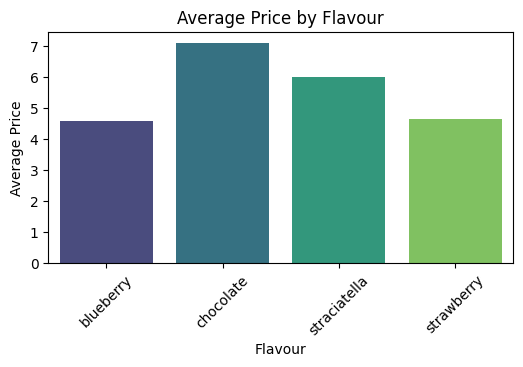

In [25]:
# Plot average price per flavour
plt.figure(figsize=(6,3))
sns.barplot(data=flavour_analysis, x="flavour", y="avg_price", palette="viridis")
plt.xlabel("Flavour")
plt.ylabel("Average Price")
plt.title("Average Price by Flavour")
plt.xticks(rotation=45)
plt.show()

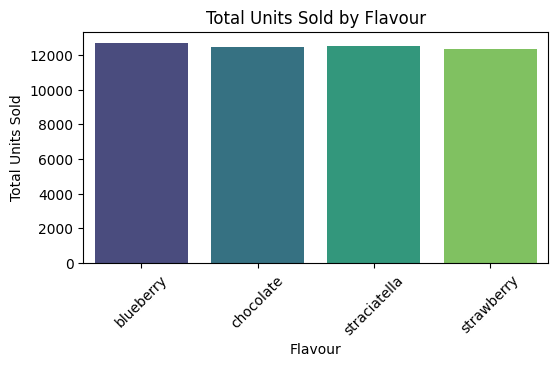

In [26]:
# Plot total units sold per flavour
plt.figure(figsize=(6,3))
sns.barplot(data=flavour_analysis, x="flavour", y="total_units_sold", palette="viridis")
plt.xlabel("Flavour")
plt.ylabel("Total Units Sold")
plt.title("Total Units Sold by Flavour")
plt.xticks(rotation=45)
plt.show()

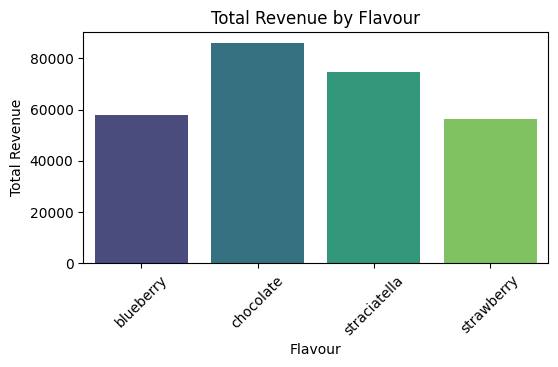

In [27]:
# Plot revenue per flavour
plt.figure(figsize=(6,3))
sns.barplot(data=flavour_analysis, x="flavour", y="total_revenue", palette="viridis")
plt.xlabel("Flavour")
plt.ylabel("Total Revenue")
plt.title("Total Revenue by Flavour")
plt.xticks(rotation=45)
plt.show()

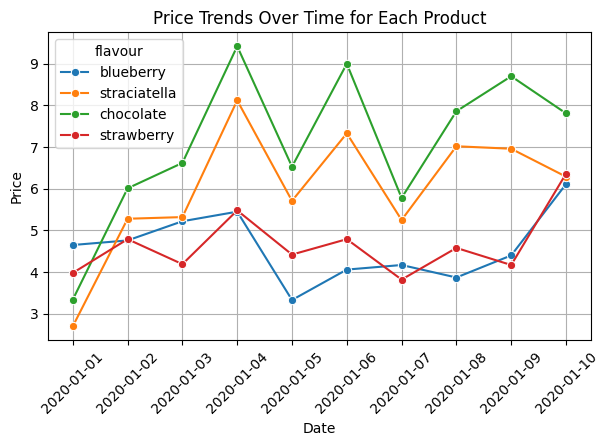

In [28]:
# Plot price trends for each flavor
plt.figure(figsize=(7,4))
sns.lineplot(data=mueller_df, x="date", y="price", hue="flavour", marker="o")
plt.xlabel("Date")
plt.ylabel("Price")
plt.title("Price Trends Over Time for Each Product")
plt.xticks(rotation=45)
plt.grid()
plt.show()

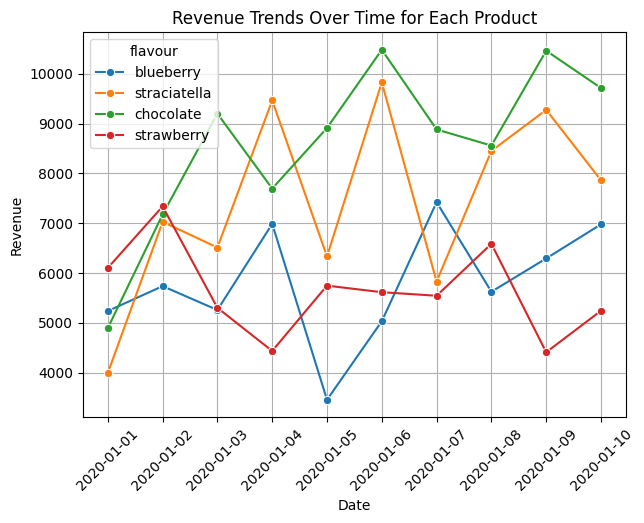

In [29]:
# Plot revenue trends for each flavor
plt.figure(figsize=(7,5))
sns.lineplot(data=mueller_df, x="date", y="revenue", hue="flavour", marker="o")
plt.xlabel("Date")
plt.ylabel("Revenue")
plt.title("Revenue Trends Over Time for Each Product")
plt.xticks(rotation=45)
plt.grid()
plt.show()

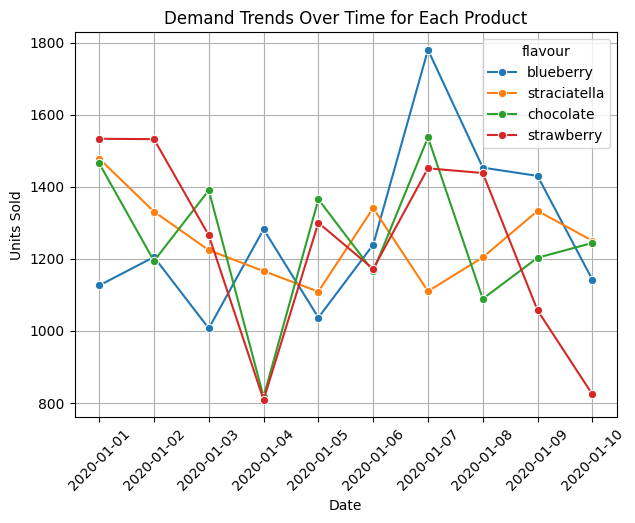

In [30]:
# Plot revenue trends for each flavor
plt.figure(figsize=(7,5))
sns.lineplot(data=mueller_df, x="date", y="units", hue="flavour", marker="o")
plt.xlabel("Date")
plt.ylabel("Units Sold")
plt.title("Demand Trends Over Time for Each Product")
plt.xticks(rotation=45)
plt.grid()
plt.show()

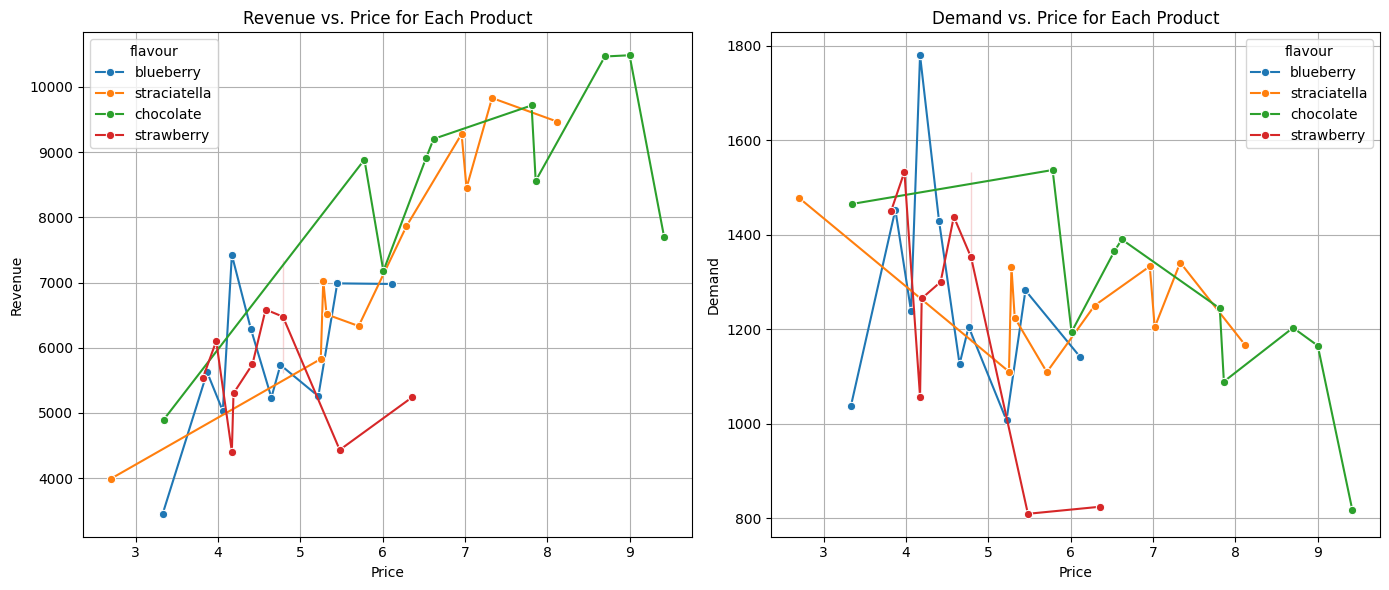

In [31]:
# Creating a figure with 2 subplots (1 row, 2 columns)
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14,6))

# Price vs. Revenue

sns.lineplot(data=mueller_df, x="price", y="revenue", hue="flavour", marker="o", linestyle="-", ax=axes[0])
axes[0].set_xlabel("Price")
axes[0].set_ylabel("Revenue")
axes[0].set_title("Revenue vs. Price for Each Product")
axes[0].grid()

# Price vs. Units Sold  
sns.lineplot(data=mueller_df, x="price", y="units", hue="flavour", marker="o", linestyle="-", ax=axes[1])
axes[1].set_xlabel("Price")
axes[1].set_ylabel("Demand")
axes[1].set_title("Demand vs. Price for Each Product")
axes[1].grid()

plt.tight_layout()
plt.show()

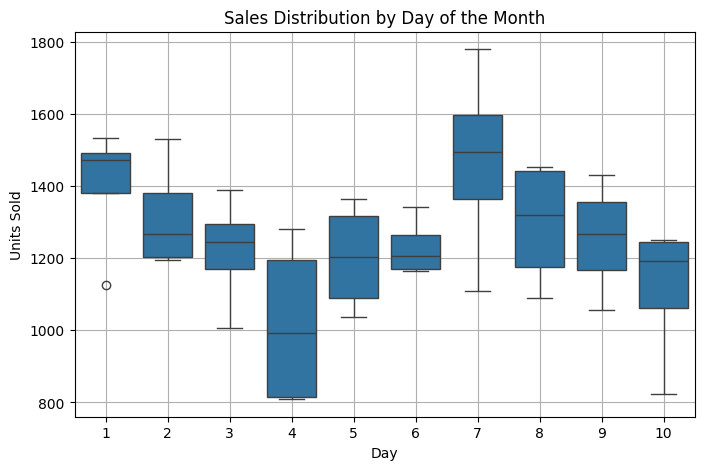

In [32]:
plt.figure(figsize=(8,5))
sns.boxplot(data=mueller_df, x="day", y="units")
plt.xlabel("Day")
plt.ylabel("Units Sold")
plt.title("Sales Distribution by Day of the Month")
plt.grid()
plt.show()

In [33]:
# Compute Q1 (25th percentile) and Q3 (75th percentile)
Q1 = mueller_df["units"].quantile(0.25)
Q3 = mueller_df["units"].quantile(0.75)

# Compute IQR
IQR = Q3 - Q1

# Define lower and upper bounds for outliers
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Identify outliers
outliers = mueller_df[(mueller_df["units"] < lower_bound) | (mueller_df["units"] > upper_bound)]

# Display the outliers
print(outliers)


Empty DataFrame
Columns: [product_id, brand, flavour, volume_per_joghurt_g, packsize, packsize_category, price, units, revenue, date, year, month, day, day_of_week]
Index: []


In [34]:
from scipy import stats

# Compute Z-scores
mueller_df["z_score"] = stats.zscore(mueller_df["units"])

# Identify outliers (absolute Z-score > 3)
outliers_z = mueller_df[mueller_df["z_score"].abs() > 3]

# Display outliers
print(outliers_z)

Empty DataFrame
Columns: [product_id, brand, flavour, volume_per_joghurt_g, packsize, packsize_category, price, units, revenue, date, year, month, day, day_of_week, z_score]
Index: []


# **Developing a Model to Predict Units Sold Based on Price (Elasticity Model)**

## We need to predict units sold from price using elasticity and product attributes. This involves:
1. Understanding Price Elasticity (How demand changes with price)
2. Building a Regression Model (Units ~ Price + Product Attributes)
3. Fitting the Model to Data
4. Evaluating Risk Against a Baseline Model

### **Including Competitor Analysis**

In [35]:
# competitor data
competitor_data = merged_data[merged_data["brand"] != "Mueller"]
competitor_data.sample(7)

,product_id,brand,flavour,volume_per_joghurt_g,packsize,packsize_category,price,units,revenue,date,year,month,day,day_of_week
62,6,Alnatura,raspberry,500,6,Multipack,6.15,1294.0,7958.10,2020-01-03,2020,Jan,3,Fri
84,8,Alnatura,straciatella,150,6,Multipack,5.20,1446.0,7519.20,2020-01-08,2020,Jan,8,Wed
118,12,Ecke-Mit-Was-Drin,straciatella,500,6,Multipack,3.27,1425.0,4659.75,2020-01-02,2020,Jan,2,Thu
162,16,Ja!,straciatella,500,6,Multipack,6.66,1723.0,11475.18,2020-01-08,2020,Jan,8,Wed
82,8,Alnatura,straciatella,150,6,Multipack,4.52,1559.0,7046.68,2020-01-06,2020,Jan,6,Mon
149,15,Oikos,chocolate,500,6,Multipack,6.50,1068.0,6942.00,2020-01-05,2020,Jan,5,Sun
213,22,Ecke-Mit-Was-Drin,raspberry,1000,6,Multipack,8.84,16.0,141.44,2020-01-03,2020,Jan,3,Fri


In [36]:
# Aggregate competitor sales per flavour and date
competitor_summary = competitor_data.groupby(["date", "flavour"]).agg(
    avg_competitor_price=("price", "mean"),
    total_competitor_sales=("units", "sum")
).reset_index()
competitor_summary.sample(7)

,date,flavour,avg_competitor_price,total_competitor_sales
24,2020-01-05,strawberry,4.670000,4627.0
47,2020-01-10,raspberry,6.416667,2728.0
38,2020-01-08,straciatella,6.640000,6691.0
3,2020-01-01,straciatella,2.712000,7298.0
15,2020-01-04,blueberry,5.866667,6393.0
45,2020-01-10,blueberry,6.402500,3595.0
36,2020-01-08,chocolate,6.232500,5731.0


In [37]:
# Merge competitor metrics into Mueller dataset
mueller_df = mueller_df.merge(competitor_summary, on=["date", "flavour"], how="left")

# Fill NaN values (if no competitor data is available for a date/flavour)
mueller_df["avg_competitor_price"].fillna(mueller_df["price"].mean(), inplace=True)
mueller_df["total_competitor_sales"].fillna(0, inplace=True)

In [38]:
mueller_df.isna().sum()

product_id                0
brand                     0
flavour                   0
volume_per_joghurt_g      0
packsize                  0
packsize_category         0
price                     0
units                     0
revenue                   0
date                      0
year                      0
month                     0
day                       0
day_of_week               0
z_score                   0
avg_competitor_price      0
total_competitor_sales    0
dtype: int64

### ****Feature Extraction****

In [39]:
# sorting the dataset by date for correct calculations
mueller_df = mueller_df.sort_values(by="date")

In [40]:
# Compute Mueller's % Change in Sales (Demand Sensitivity)
mueller_df["pct_change_units"] = mueller_df["units"].pct_change()


In [41]:
# Compute % Change in Mueller's Price
mueller_df["pct_change_price"] = mueller_df["price"].pct_change()

In [42]:
# Compute % Change in Competitor Price
mueller_df["pct_change_competitor_price"] = mueller_df["avg_competitor_price"].pct_change()


In [43]:
# Compute % Change in Competitor Sales
mueller_df["pct_change_competitor_sales"] = mueller_df["total_competitor_sales"].pct_change()

In [44]:
# Compute Elasticities 
mueller_df["own_price_elasticity"] = mueller_df["pct_change_units"] / mueller_df["pct_change_price"] 
mueller_df["cross_elasticity_price"] = mueller_df["pct_change_units"] / mueller_df["pct_change_competitor_price"]  # Sensitivity to competitor price
mueller_df["cross_elasticity_sales"] = mueller_df["pct_change_units"] / mueller_df["pct_change_competitor_sales"] # Sensitivity to competitor sales


In [45]:

# Drop first row due to pct_change NaNs
mueller_df = mueller_df.dropna()

### Preparing Data for Modeling

In [46]:
# Ensure no zero values before applying log (avoid log(0) issue)
mueller_df = mueller_df[mueller_df["price"] > 0]
mueller_df = mueller_df[mueller_df["units"] > 0]

####  **Log transformations**

In [47]:
# Mueller Price & Demand
mueller_df["log_units"] = np.log(mueller_df["units"])
mueller_df["log_price"] = np.log(mueller_df["price"])

In [48]:
# Competitors Average Price & Total Sales
mueller_df["log_avg_competitor_price"] = np.log(mueller_df["avg_competitor_price"])
mueller_df["log_total_competitor_sales"] = np.log1p(mueller_df["total_competitor_sales"]) # This uses log(1 + x) instead of log(x), avoiding -inf when sales are 0


In [49]:
# sum of na > 0
mueller_df.isna().sum()[mueller_df.isna().sum() > 0]

Series([], dtype: int64)

In [50]:
# I copied the data for later use in PCA analysis
data_pca = mueller_df.copy()

### Train a Regression Model

#### Encode Categorical Variables (packsize_category, flavour, day_of_week)

In [51]:
# Converting categorical variables into dummy variables
mueller_df = pd.get_dummies(mueller_df, columns=["flavour", "day_of_week","volume_per_joghurt_g"], drop_first=True)

<span style = "color:red" > [Note] In this dataset, Monday, Tuesday, and Wednesday each appear twice, while other days appear only once. This imbalance can introduce noise when using “day_of_week” as a categorical variable since the limited time span (only 10 days) does not provide a full picture of weekly sales patterns. As a result, any observed effects may not generalize well, making it a potential drawback in the analysis. </span>

In [52]:
mueller_df.columns

Index(['product_id', 'brand', 'packsize', 'packsize_category', 'price',
       'units', 'revenue', 'date', 'year', 'month', 'day', 'z_score',
       'avg_competitor_price', 'total_competitor_sales', 'pct_change_units',
       'pct_change_price', 'pct_change_competitor_price',
       'pct_change_competitor_sales', 'own_price_elasticity',
       'cross_elasticity_price', 'cross_elasticity_sales', 'log_units',
       'log_price', 'log_avg_competitor_price', 'log_total_competitor_sales',
       'flavour_chocolate', 'flavour_straciatella', 'flavour_strawberry',
       'day_of_week_Mon', 'day_of_week_Sat', 'day_of_week_Sun',
       'day_of_week_Thu', 'day_of_week_Tue', 'day_of_week_Wed',
       'volume_per_joghurt_g_500', 'volume_per_joghurt_g_1000'],
      dtype='object')

#### Defining Features and Label

In [53]:
# Define independent variables
X = mueller_df[["log_price","log_avg_competitor_price", "log_total_competitor_sales","cross_elasticity_price","cross_elasticity_sales"] + 
               [col for col in mueller_df.columns if col.startswith("flavour_")] + 
               [col for col in mueller_df.columns if col.startswith("day_of_week_")] + 
               [col for col in mueller_df.columns if col.startswith("volume_per_joghurt_g_")]]

# Add intercept term
X = sm.add_constant(X)

In [54]:
X = X.astype(int)  # Convert all bool columns to int (0/1)
print(X.dtypes)  # Check results

const                         int64
log_price                     int64
log_avg_competitor_price      int64
log_total_competitor_sales    int64
cross_elasticity_price        int64
cross_elasticity_sales        int64
flavour_chocolate             int64
flavour_straciatella          int64
flavour_strawberry            int64
day_of_week_Mon               int64
day_of_week_Sat               int64
day_of_week_Sun               int64
day_of_week_Thu               int64
day_of_week_Tue               int64
day_of_week_Wed               int64
volume_per_joghurt_g_500      int64
volume_per_joghurt_g_1000     int64
dtype: object


In [55]:
X.head()

,const,log_price,log_avg_competitor_price,log_total_competitor_sales,cross_elasticity_price,cross_elasticity_sales,flavour_chocolate,flavour_straciatella,flavour_strawberry,day_of_week_Mon,day_of_week_Sat,day_of_week_Sun,day_of_week_Thu,day_of_week_Tue,day_of_week_Wed,volume_per_joghurt_g_500,volume_per_joghurt_g_1000
30,1,1,1,8,-1,7,0,0,1,0,0,0,0,0,1,0,0
10,1,0,0,8,0,0,0,1,0,0,0,0,0,0,1,1,0
20,1,1,0,8,0,0,1,0,0,0,0,0,0,0,1,0,1
21,1,1,1,8,0,1,1,0,0,0,0,0,1,0,0,0,1
1,1,1,1,8,0,0,0,0,0,0,0,0,1,0,0,0,0


In [56]:
# Define dependent variable (log of units sold)
y = mueller_df["log_units"]

In [57]:
y.head()

30    7.334982
10    7.298445
20    7.289611
21    7.085064
1     7.094235
Name: log_units, dtype: float64

#### Fit the Model

In [58]:
# Fit an OLS regression model
model = sm.OLS(y, X).fit()

# Display model summary
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:              log_units   R-squared:                       0.539
Model:                            OLS   Adj. R-squared:                  0.300
Method:                 Least Squares   F-statistic:                     2.251
Date:                Thu, 20 Mar 2025   Prob (F-statistic):             0.0395
Time:                        12:51:03   Log-Likelihood:                 28.533
No. Observations:                  39   AIC:                            -29.07
Df Residuals:                      25   BIC:                            -5.777
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
const               

In [59]:
# Compute Residual Sum of Squares (RSS)
RSS = np.sum(model.resid ** 2)

# Compute Total Sum of Squares (TSS)
TSS = np.sum((y - y.mean()) ** 2)

# Compute Explained Sum of Squares (ESS)
ESS = TSS - RSS

# Compute RMSE (Root Mean Squared Error)
RMSE = np.sqrt(RSS / len(y))

# Compute MAE (Mean Absolute Error)
MAE = np.mean(np.abs(model.resid))

# Display Additional Metrics
print(f"Residual Sum of Squares (RSS): {RSS:.4f}")
print(f"Total Sum of Squares (TSS): {TSS:.4f}")
print(f"Explained Sum of Squares (ESS): {ESS:.4f}")
print(f"Root Mean Squared Error (RMSE): {RMSE:.4f}")
print(f"Mean Absolute Error (MAE): {MAE:.4f}")

Residual Sum of Squares (RSS): 0.5286
Total Sum of Squares (TSS): 1.1473
Explained Sum of Squares (ESS): 0.6187
Root Mean Squared Error (RMSE): 0.1164
Mean Absolute Error (MAE): 0.0945


**Model Evaluation Summary**


#### Checking for multicollinearity using the Variance Inflation Factor (VIF)
- Drop variables with very high VIF (>5) to reduce multicollinearity.

In [60]:
# Calculate VIF for each variable
vif_data = pd.DataFrame()
vif_data["Variable"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

print(vif_data)

                      Variable       VIF
0                        const  0.000000
1                    log_price  2.686300
2     log_avg_competitor_price  2.085018
3   log_total_competitor_sales  0.000000
4       cross_elasticity_price  1.222735
5       cross_elasticity_sales  1.299594
6            flavour_chocolate       inf
7         flavour_straciatella       inf
8           flavour_strawberry  1.683135
9              day_of_week_Mon  1.423514
10             day_of_week_Sat  1.739555
11             day_of_week_Sun  1.420310
12             day_of_week_Thu  1.671282
13             day_of_week_Tue  1.415767
14             day_of_week_Wed  2.148225
15    volume_per_joghurt_g_500       inf
16   volume_per_joghurt_g_1000       inf


## Visualizations based on the model

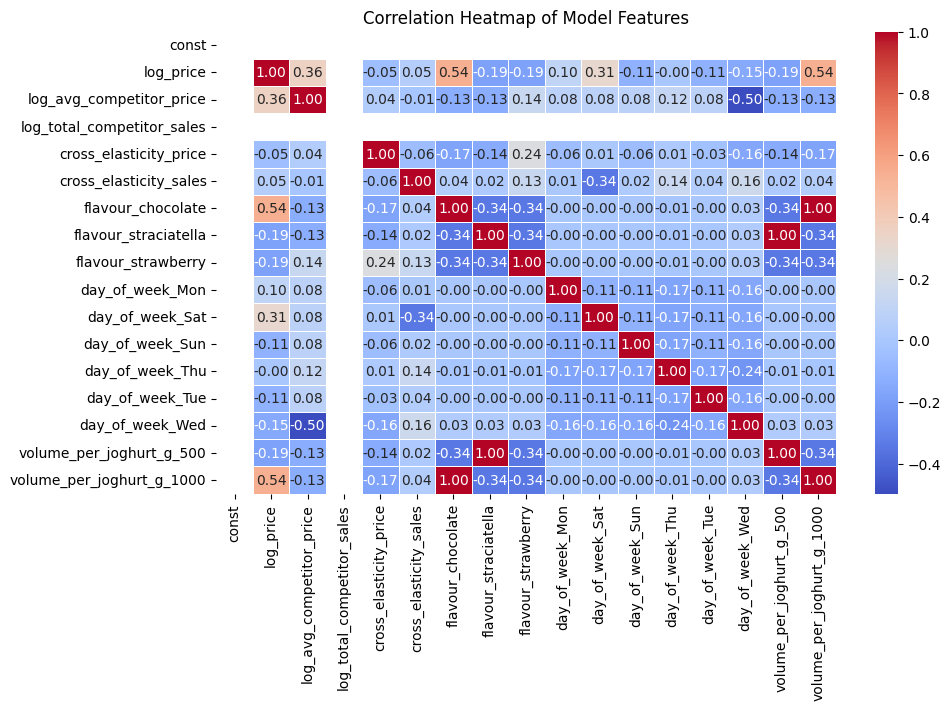

In [61]:
# Compute the correlation matrix for independent variables
correlation_matrix = X.corr()

# Create a heatmap
plt.figure(figsize=(10,6))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)

# Add title
plt.title("Correlation Heatmap of Model Features")

# Show the plot
plt.show()

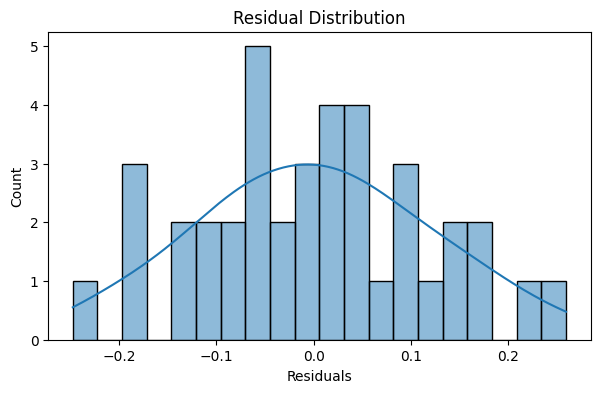

In [62]:
residuals = model.resid
plt.figure(figsize=(7,4))
sns.histplot(residuals, bins=20, kde=True)
plt.xlabel("Residuals")
plt.title("Residual Distribution")
plt.show()

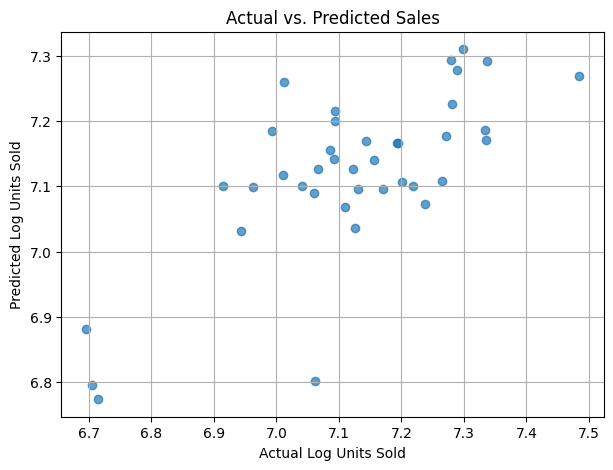

In [63]:
plt.figure(figsize=(7,5))
plt.scatter(y, model.fittedvalues, alpha=0.7)
plt.xlabel("Actual Log Units Sold")
plt.ylabel("Predicted Log Units Sold")
plt.title("Actual vs. Predicted Sales")
plt.grid()
plt.show()

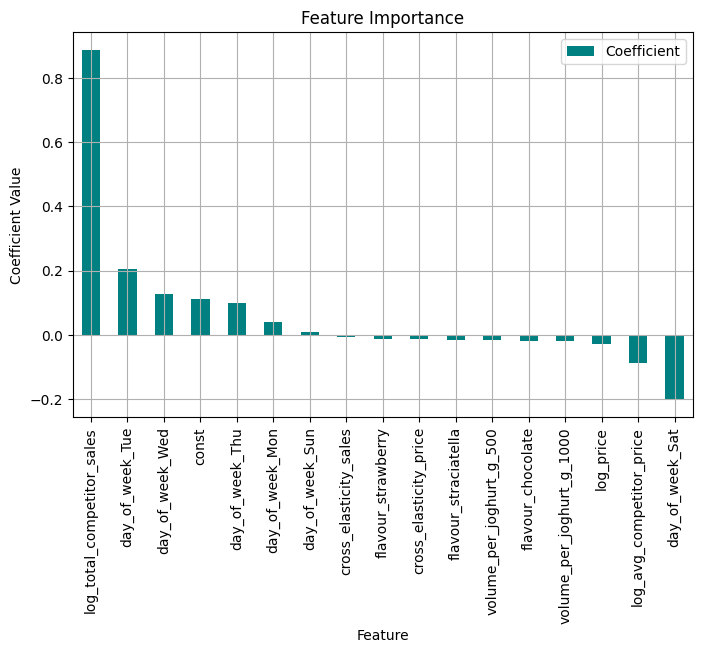

In [64]:
coef_df = pd.DataFrame({"Feature": X.columns, "Coefficient": model.params}).set_index("Feature")
coef_df.sort_values(by="Coefficient", ascending=False).plot(kind="bar", figsize=(8,5), color="teal")
plt.title("Feature Importance")
plt.ylabel("Coefficient Value")
plt.grid()
plt.show()

## **PCA Analysis**

In [65]:
# Select numerical features for PCA (exclude categorical features)
num_features = ["log_price", "log_avg_competitor_price", "log_total_competitor_sales",
                "cross_elasticity_price", "cross_elasticity_sales", "volume_per_joghurt_g"]


In [66]:
# Standardize numerical features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(data_pca[num_features])


In [67]:
# Apply PCA
pca = PCA(n_components=3)  # Reduce to 3 components
X_pca = pca.fit_transform(X_scaled)

In [68]:
# Convert PCA components to DataFrame
pca_columns = [f"PC{i+1}" for i in range(X_pca.shape[1])]
X_pca_df = pd.DataFrame(X_pca, columns=pca_columns)

In [69]:
X_pca_df.head()

,PC1,PC2,PC3
0,-1.401634,-0.542737,0.206412
1,-0.030819,-3.340235,-0.652882
2,1.222122,-3.570263,0.582641
3,1.633493,-1.240978,1.151646
4,-0.728887,-0.057518,-0.630141


In [70]:
# One-hot encode categorical variables
categorical_features = ["flavour", "day_of_week"]
X_categorical = pd.get_dummies(data_pca[categorical_features], drop_first= True)


In [71]:
# Concatenate PCA-transformed features with one-hot encoded categorical features
X_final = pd.concat([X_pca_df, X_categorical.reset_index(drop=True)], axis=1)


In [72]:
X_final.head()

,PC1,PC2,PC3,flavour_chocolate,flavour_straciatella,flavour_strawberry,day_of_week_Mon,day_of_week_Sat,day_of_week_Sun,day_of_week_Thu,day_of_week_Tue,day_of_week_Wed
0,-1.401634,-0.542737,0.206412,False,False,True,False,False,False,False,False,True
1,-0.030819,-3.340235,-0.652882,False,True,False,False,False,False,False,False,True
2,1.222122,-3.570263,0.582641,True,False,False,False,False,False,False,False,True
3,1.633493,-1.240978,1.151646,True,False,False,False,False,False,True,False,False
4,-0.728887,-0.057518,-0.630141,False,False,False,False,False,False,True,False,False


In [73]:
X_final = X_final.astype(float)
X_final.head()

,PC1,PC2,PC3,flavour_chocolate,flavour_straciatella,flavour_strawberry,day_of_week_Mon,day_of_week_Sat,day_of_week_Sun,day_of_week_Thu,day_of_week_Tue,day_of_week_Wed
0,-1.401634,-0.542737,0.206412,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
1,-0.030819,-3.340235,-0.652882,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,1.222122,-3.570263,0.582641,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,1.633493,-1.240978,1.151646,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,-0.728887,-0.057518,-0.630141,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


In [74]:
# Target variable
y_pca = data_pca["log_units"].reset_index(drop = True)

In [75]:
# Add constant for intercept
X_final = sm.add_constant(X_final)

# Fit OLS regression model with PCA-transformed features
model_pca = sm.OLS(y_pca, X_final).fit()

# Display results
print(model_pca.summary())

                            OLS Regression Results                            
Dep. Variable:              log_units   R-squared:                       0.495
Model:                            OLS   Adj. R-squared:                  0.263
Method:                 Least Squares   F-statistic:                     2.128
Date:                Thu, 20 Mar 2025   Prob (F-statistic):             0.0521
Time:                        12:51:04   Log-Likelihood:                 26.762
No. Observations:                  39   AIC:                            -27.52
Df Residuals:                      26   BIC:                            -5.897
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                    7.1040 

In [76]:
# Compute Residual Sum of Squares (RSS)
RSS_pca = np.sum(model_pca.resid ** 2)

# Compute Total Sum of Squares (TSS)
TSS_pca = np.sum((y_pca - y_pca.mean()) ** 2)

# Compute Explained Sum of Squares (ESS)
ESS_pca = TSS_pca - RSS_pca

# Compute RMSE (Root Mean Squared Error)
RMSE_pca = np.sqrt(RSS_pca / len(y_pca))

# Compute MAE (Mean Absolute Error)
MAE_pca = np.mean(np.abs(model_pca.resid))

# Display Additional Metrics
print(f"Residual Sum of Squares (RSS): {RSS_pca:.4f}")
print(f"Total Sum of Squares (TSS): {TSS_pca:.4f}")
print(f"Explained Sum of Squares (ESS): {ESS_pca:.4f}")
print(f"Root Mean Squared Error (RMSE): {RMSE_pca:.4f}")
print(f"Mean Absolute Error (MAE): {MAE_pca:.4f}")

Residual Sum of Squares (RSS): 0.5789
Total Sum of Squares (TSS): 1.1473
Explained Sum of Squares (ESS): 0.5684
Root Mean Squared Error (RMSE): 0.1218
Mean Absolute Error (MAE): 0.0998


In [77]:
# Calculate VIF for each variable
vif_data_pca = pd.DataFrame()
vif_data_pca["Variable"] = X_final.columns
vif_data_pca["VIF"] = [variance_inflation_factor(X_final.values, i) for i in range(X_final.shape[1])]

print(vif_data_pca)

                Variable        VIF
0                  const  48.991238
1                    PC1  35.210525
2                    PC2   1.339012
3                    PC3   5.447875
4      flavour_chocolate  46.295248
5   flavour_straciatella  16.721198
6     flavour_strawberry   2.362383
7        day_of_week_Mon   1.459210
8        day_of_week_Sat   1.740387
9        day_of_week_Sun   1.694417
10       day_of_week_Thu   1.735648
11       day_of_week_Tue   1.591205
12       day_of_week_Wed   1.995078


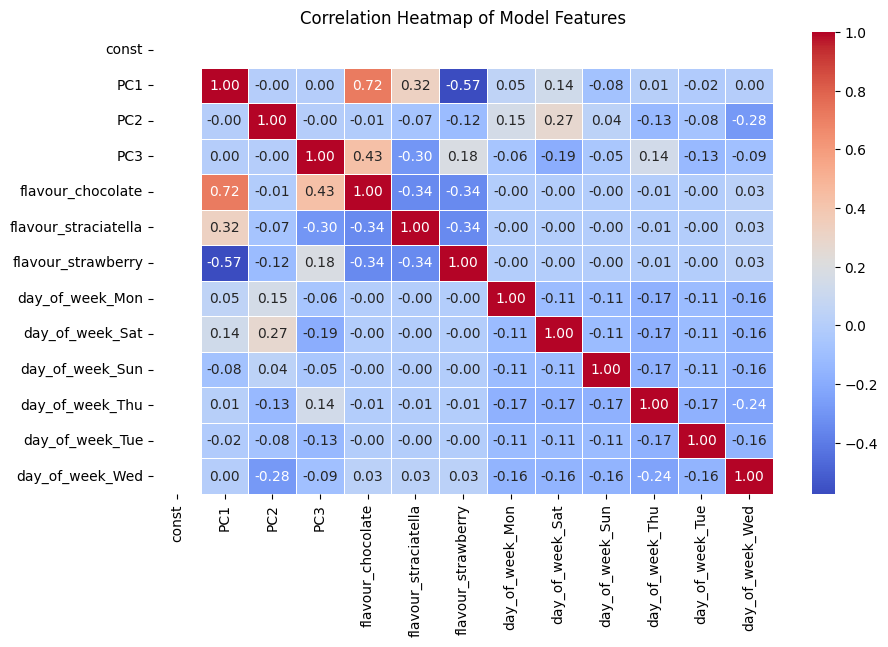

In [78]:
# Compute the correlation matrix for independent variables
correlation_matrix_pca = X_final.corr()

# Create a heatmap
plt.figure(figsize=(10,6))
sns.heatmap(correlation_matrix_pca, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)

# Add title
plt.title("Correlation Heatmap of Model Features")

# Show the plot
plt.show()

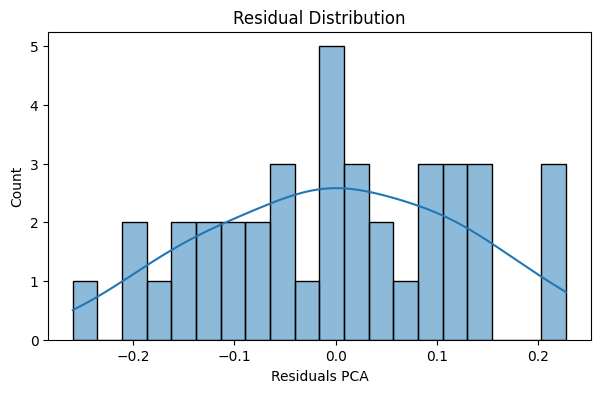

In [79]:
residuals_pca = model_pca.resid
plt.figure(figsize=(7,4))
sns.histplot(residuals_pca, bins=20, kde=True)
plt.xlabel("Residuals PCA")
plt.title("Residual Distribution")
plt.show()

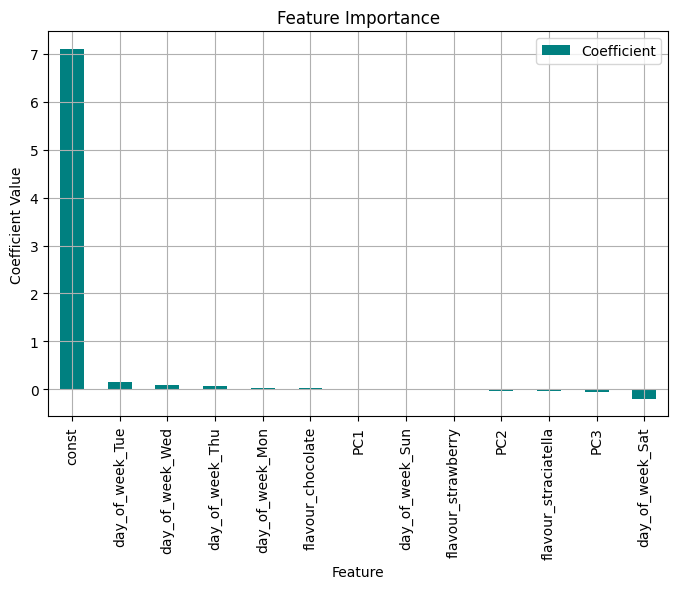

In [80]:
coef_df_pca = pd.DataFrame({"Feature": X_final.columns, "Coefficient": model_pca.params}).set_index("Feature")
coef_df_pca.sort_values(by="Coefficient", ascending=False).plot(kind="bar", figsize=(8,5), color="teal")
plt.title("Feature Importance")
plt.ylabel("Coefficient Value")
plt.grid()
plt.show()

# **Mueller Price Optimization: Final Summary**

## **Objective**
This project focuses on optimizing **Mueller yogurt pricing** by analyzing:
- The relationship between **price and sales** (own-price elasticity).
- The impact of **competitor pricing and sales** (cross-price elasticity).
- The use of **dimensionality reduction (PCA)** to improve model efficiency.
- How to **enhance model performance** for revenue optimization.

---

## **1. Data Integration & Competitor Analysis**
To understand the market better, we incorporated **competitor data**, specifically:
- **Average competitor price** per flavor, pack size, and date.
- **Total competitor sales** to assess overall market trends.

We then computed **cross-price elasticity** to measure **how changes in competitor pricing impact Mueller's sales**.

 **Key Finding**: Competitor total sales were **the strongest predictor of Mueller's demand**, suggesting that market size fluctuations impact sales more than price changes.

---

## **2. Regression Model: Price & Competition Effects**
We developed a **multiple regression model** including:
- **Log-transformed own-price and competitor price**
- **Competitor sales volume**
- **Cross-price elasticity**
- **Product attributes (flavor, pack size, day of the week)**

 **Model Results**:
- **Own-price elasticity was weak (-0.0278, p=0.771)** → Mueller’s sales were **not highly sensitive** to price.
- **Competitor sales had a strong positive impact (+0.8883, p=0.000)** → Suggests **demand is more influenced by overall market trends**.
- **Cross-price elasticity was small (-0.0139, p=0.047)** → Mueller products may be **weak substitutes** for competitors.

 **Insight**: Price **alone** may not be the best revenue driver; **market demand trends and competitive positioning matter more**.

--- 

## **3. Principal Component Analysis (PCA)**
To reduce dimensionality and multicollinearity, we applied **PCA** on numerical features:
- `log_price`, `log_avg_competitor_price`, `log_total_competitor_sales`
- `cross_elasticity_price`, `cross_elasticity_sales`

However, **PCA did not improve model accuracy** (R² decreased from **0.539** to **0.495**) and reduced interpretability.

 **Insight**: **PCA was not effective**, as categorical variables (flavor, day of the week) were still dominant. Traditional feature selection may be better.

---

## **4. Key Takeaways & Recommendations**
 **Competitor sales were the strongest predictor** → Pricing strategy should **align with market trends**.  
 **Mueller's demand was price-inelastic** → A price reduction **may not lead to higher revenue**.  
 **PCA did not enhance the model** → Keep feature selection **focused on interpretability**.  

### **Next Steps**
 **Alternative Modeling Approaches**:
- **Regularization (Ridge/Lasso Regression)** to handle multicollinearity.
- **Interaction Terms** (e.g., `competitor price × day of week`) to capture demand fluctuations.
- **Time-Series Analysis (ARIMA, VAR)** to forecast sales trends over time.
- **Machine Learning Models (Gradient Boosting, Random Forest)** to capture nonlinear effects.

 **Expanding Competitor Analysis**:  
Future work should **compare Mueller vs. competitor elasticities** directly for **market-wide revenue optimization**.

---

### **Conclusion**
This analysis highlights that **price is not the sole driver of sales**. **Market trends, competitor positioning, and demand forecasting** play a **critical role** in optimizing revenue. Future improvements should incorporate **more advanced modeling techniques** and **a broader competitor perspective**.

--- 



# <span style ="color:red"> **Limitations of Linear Demand Models and the Advantage of AI in Pricing Optimization**</span>

## **Limitations of Linear Demand Models**
Traditional linear demand models, such as the OLS-based approach, have several limitations that make them less effective in complex, dynamic pricing environments:

1. **Assumption of a Constant Relationship**  
   - Linear models assume that price and demand have a fixed relationship, meaning that a 1% change in price will always lead to a specific percentage change in sales.  
   - In reality, consumer behavior is non-linear, and factors like **promotions, competitor actions, and psychological pricing effects** can cause abrupt changes in demand.

2. **Lack of Adaptability to Market Changes**  
   - These models rely on historical data and assume future patterns will behave similarly.  
   - They struggle to **adapt to real-time shifts**, such as competitor promotions, seasonal changes, or shifts in consumer preferences.

3. **Limited Incorporation of Consumer Behavior**  
   - Linear models typically account for measurable variables (e.g., price, competitor sales) but fail to capture **consumer psychology, brand perception, and decision-making under uncertainty**.  
   - They do not account for **price perception, brand loyalty, or impulse purchasing behaviors**.

4. **Challenges with Multicollinearity**  
   - When multiple pricing and sales-related variables are highly correlated (e.g., **own price, competitor prices, cross-elasticities**), it causes unstable coefficient estimates, reducing model reliability.

5. **Inability to Simulate Competitive Scenarios**  
   - Linear models do not allow for scenario-based simulations to test **different pricing and promotional strategies dynamically**.  
   - Businesses using these models often struggle with **predicting the impact of strategic pricing decisions**.

---

## **Why Use AI and Virtual Shoppers for Pricing Optimization?**
AI-based pricing models, such as **Virtual Shoppers** used by Buynomics, provide a **more dynamic, adaptive, and behavior-driven approach** to pricing and demand forecasting. Here’s how:

1. **Capturing Non-Linear Consumer Behavior**  
   - AI-driven models **simulate real consumer decision-making** rather than assuming a fixed demand response.  
   - They incorporate **threshold effects, brand preferences, and cross-category influences** that traditional models overlook.

2. **Real-Time Adaptability**  
   - Unlike static regression models, AI systems continuously learn from **market conditions, competitor pricing, and changing demand patterns**.  
   - AI-based models **adjust dynamically** to changes in consumer sentiment, competitor promotions, and supply chain disruptions.

3. **Advanced Behavioral Insights**  
   - Virtual shoppers **mimic real purchasing behavior** under various scenarios, helping businesses **test different pricing strategies before implementation**.  
   - This helps identify **optimal price points and promotion strategies** without relying solely on historical data.

4. **Handling Multicollinearity and Complex Relationships**  
   - AI models can naturally account for **correlations between multiple variables** without causing instability.  
   - Advanced techniques like **regularization (Lasso, Ridge) and deep learning** help extract meaningful insights from interdependent factors.

5. **Scenario Simulation for Competitive Pricing**  
   - AI models **simulate competitive market conditions** by incorporating **consumer elasticity, brand switching tendencies, and reaction to price changes**.  
   - Businesses can test **"What-if" scenarios**, such as:
     - What happens if a competitor lowers prices by 10%?
     - How will our revenue change if we increase price but add a discount?

---

## **Conclusion**
Traditional linear models, while useful for basic demand estimation, are **limited in handling complex pricing environments**. AI-based pricing models, especially those using **Virtual Shoppers and advanced machine learning**, provide:

 **More accurate demand forecasts**  
 **Adaptive real-time pricing strategies**  
 **Consumer behavior-driven insights**  
 **Better handling of competitive interactions**  

By leveraging AI, businesses can **optimize pricing strategies, maximize revenue, and stay competitive in dynamic markets**.